In [ ]:
import  numpy as np
import os
import pandas as pd
from    sklearn.feature_extraction.text import TfidfVectorizer
from    sklearn.metrics    import precision_recall_fscore_support, accuracy_score
from    sklearn.model_selection import train_test_split 
from    sklearn.preprocessing   import LabelEncoder
from    sklearn.svm             import LinearSVC
from tqdm.auto import tqdm

In [ ]:
!wget https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz
!tar xvf empatheticdialogues.tar.gz

--2020-12-01 04:25:04--  https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28022709 (27M) [application/gzip]
Saving to: ‘empatheticdialogues.tar.gz’

empatheticdialogues 100%[===================>]  26.72M  15.1MB/s    in 1.8s    

2020-12-01 04:25:07 (15.1 MB/s) - ‘empatheticdialogues.tar.gz’ saved [28022709/28022709]

empatheticdialogues/
empatheticdialogues/test.csv
empatheticdialogues/train.csv
empatheticdialogues/valid.csv


In [ ]:
def prepare_dataset(target_file):
  dataset_dir = os.path.join(os.getcwd(),'empatheticdialogues')

  examples = {}

  for file in tqdm(os.listdir(dataset_dir)):
    if file == target_file + '.csv':
      file_path = os.path.join(dataset_dir,file)
      return pd.read_csv(file_path,error_bad_lines=False)
    
    

In [ ]:
train = prepare_dataset('train')
valid = prepare_dataset('valid')
test =  prepare_dataset('test')

b'Skipping line 2355: expected 8 fields, saw 10\nSkipping line 36628: expected 8 fields, saw 12\nSkipping line 49433: expected 8 fields, saw 10\nSkipping line 56957: expected 8 fields, saw 10\nSkipping line 65019: expected 8 fields, saw 10\n'


b'Skipping line 2355: expected 8 fields, saw 10\nSkipping line 36628: expected 8 fields, saw 12\nSkipping line 49433: expected 8 fields, saw 10\nSkipping line 56957: expected 8 fields, saw 10\nSkipping line 65019: expected 8 fields, saw 10\n'


b'Skipping line 2355: expected 8 fields, saw 10\nSkipping line 36628: expected 8 fields, saw 12\nSkipping line 49433: expected 8 fields, saw 10\nSkipping line 56957: expected 8 fields, saw 10\nSkipping line 65019: expected 8 fields, saw 10\n'


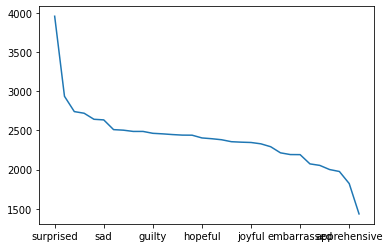

In [ ]:
train["context"].value_counts().plot()

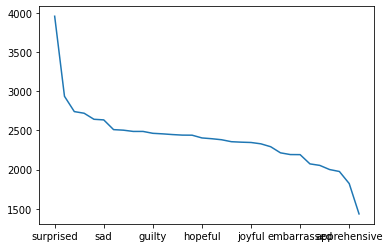

In [ ]:
valid["context"].value_counts().plot()

#Text Cleaning (removing comma and lowering all text

In [ ]:
def clean_text(dataset, column_to_clean):
  text = []
  for prompt in dataset[column_to_clean]: 
    if "_comma_" in prompt: 
      prompt = prompt.replace("_comma_", "")
    text.append(prompt.lower)
  return text

In [ ]:
train["clean_prompt"] = clean_text(train, "prompt")
valid["clean_prompt"] = clean_text(valid, "prompt")
test["clean_prompt"] = clean_text(test, "prompt")

train["clean_utterance"] = clean_text(train, "utterance")
valid["clean_utterance"] = clean_text(valid, "utterance")
test["clean_utterance"] = clean_text(test, "utterance")

#Adding in Speaker/Listener Column 
 - Creating new dataframes that are either listener or speaker

In [ ]:
 def add_speaker_listener_column(empath_df):
    speaker_listener =[]
    collect_convos = {}
    for n, conv_id in enumerate(empath_df["conv_id"]): 
      #for first instance of conversation id we assign to speaker
      if conv_id not in collect_convos:
        collect_convos[conv_id] = {"listener":[], "speaker":[]}
        collect_convos[conv_id]["speaker"].append(empath_df.iloc[[n]])
        speaker_listener.append("speaker")
        prev_check = "listen"
      # print(empath_df.iloc[[n]], n)
      #second instance would go into else statement and be list since after the first instance 
        # we set prev as listen 
          #then it'll continue to loop back and forth until the next convo 
      else:
        if prev_check == "listen":
          collect_convos[conv_id]["listener"].append(empath_df.iloc[[n]])
          speaker_listener.append("listener")
          prev_check = "speak"
        # print(empath_df.iloc[[n]], n)
        else: 
          collect_convos[conv_id]["speaker"].append(empath_df.iloc[[n]])
          speaker_listener.append("speaker")
          prev_check = "listen"
          #print(empath_df.iloc[[n]], n)
    return speaker_listener

In [ ]:
#adding in speaker and listener column so we can differentiate text
train["speaker_label"] = add_speaker_listener_column(train)
valid["speaker_label"] = add_speaker_listener_column(valid)
test["speaker_label"] = add_speaker_listener_column(test)

In [ ]:
train_speaker = train.loc[train["speaker_label"] == "speaker"]
train_listener = train.loc[train["speaker_label"] == "listener"]

valid_speaker = valid.loc[valid["speaker_label"] == "speaker"]
valid_listener = valid.loc[valid["speaker_label"] == "listener"]

test_speaker = test.loc[test["speaker_label"] == "speaker"]
test_listener = test.loc[test["speaker_label"] == "listener"]

#Adding in New Emotion Labels (Positive Negative Neutral Groups)

In [ ]:
negative_emotions = ['afraid','angry','annoyed','anxious','apprehensive','ashamed','devastated','disappointed','disgusted','embarrassed','furious','guilty','jealous','lonely','sad','terrified']
neutral_emotions = ['anticipating','faithful','hopeful','nostalgic','prepared','trusting']
positive_emotions = ['caring','confident','content','excited','grateful','impressed','joyful','proud','sentimental','surprised']

In [ ]:
def reducer(emotion):
  if emotion in negative_emotions:
    return 2
  if emotion in neutral_emotions:
    return 0
  if emotion in positive_emotions:
    return 1

In [ ]:
train['emotion_category'] = train['context'].apply(lambda emotion: reducer(emotion))
valid['emotion_category'] = valid['context'].apply(lambda emotion: reducer(emotion))
test['emotion_category'] = test['context'].apply(lambda emotion: reducer(emotion))

##Adding LIWC Features

In [ ]:
#initial import of file and loading of dictionary which is needed for the script
import word_category_counter as wc
wc.load_dictionary("LIWC2007.dic")

def add_liwc_categories(data, text_column):
  _liwc_categories = [
          ('Total Function Words', 1, 'funct', None, None),
          ('Total Pronouns', 2, 'pronoun', 1, 'pronoun'),
          ('Personal Pronouns', 3, 'ppron', None, None),
          ('First Person Singular', 4, 'i', 2, 'i'),
          ('First Person Plural', 5, 'we', 3, 'we'),
          ('Second Person', 6, 'you', 5, 'you'),
          ('Third Person Singular', 7, 'shehe', None, None),
          ('Third Person Plural', 8, 'they', None, None),
          (' Impersonal Pronouns', 9, 'ipron', None, None),
          ('Articles', 10, 'article', 9, 'article'),
          ('Common Verbs', 11, 'verb', None, None),
          ('Auxiliary Verbs', 12, 'auxverb', None, None),
          ('Past Tense', 13, 'past', 38, 'past'),
          ('Present Tense', 14, 'present', 39, 'present'),
          ('Future Tense', 15, 'future', 40, 'future'),
          ('Adverbs', 16, 'adverb', None, None),
          ('Prepositions', 17, 'preps', 10, 'preps'),
          ('Conjunctions', 18, 'conj', None, None),
          ('Negations', 19, 'negate', 7, 'negate'),
          ('Quantifiers', 20, 'quant', None, None),
          ('Number', 21, 'number', 11, 'number'),
          ('Swear Words', 22, 'swear', 66, 'swear'),
          ('Social Processes', 121, 'social', 31, 'social'),
          ('Family', 122, 'family', 35, 'family'),
          ('Friends', 123, 'friend', 34, 'friends'),
          ('Humans', 124, 'humans', 36, 'humans'),
          ('Affective Processes', 125, 'affect', 12, 'affect'),
          ('Positive Emotion', 126, 'posemo', 13, 'posemo'),
          ('Negative Emotion', 127, 'negemo', 16, 'negemo'),
          ('Anxiety', 128, 'anx', 17, 'anx'),
          ('Anger', 129, 'anger', 18, 'anger'),
          ('Sadness', 130, 'sad', 19, 'sad'),
          ('Cognitive Processes', 131, 'cogmech', 20, 'cogmech'),
          ('Insight', 132, 'insight', 22, 'insight'),
          ('Causation', 133, 'cause', 21, 'cause'),
          ('Discrepancy', 134, 'discrep', 23, 'discrep'),
          ('Tentative', 135, 'tentat', 25, 'tentat'),
          ('Certainty', 136, 'certain', 26, 'certain'),
          ('Inhibition', 137, 'inhib', 24, 'inhib'),
          ('Inclusive', 138, 'incl', 44, 'incl'),
          ('Exclusive', 139, 'excl', 45, 'excl'),
          ('Perceptual Processes', 140, 'percept', 27, 'senses'),
          ('See', 141, 'see', 28, 'see'),
          ('Hear', 142, 'hear', 29, 'hear'),
          ('Feel', 143, 'feel', 30, 'feel'),
          ('Biological Processes', 146, 'bio', None, None),
          ('Body', 147, 'body', 61, 'body'),
          ('Health', 148, 'health', None, None),
          ('Sexual', 149, 'sexual', 62, 'sexual'),
          ('Ingestion', 150, 'ingest', 63, 'eating'),
          ('Relativity', 250, 'relativ', None, None),
          ('Motion', 251, 'motion', 46, 'motion'),
          ('Space', 252, 'space', 41, 'space'),
          ('Time', 253, 'time', 37, 'time'),
          ('Work', 354, 'work', 49, 'job'),
          ('Achievement', 355, 'achieve', 50, 'achieve'),
          ('Leisure', 356, 'leisure', 51, 'leisure'),
          ('Home', 357, 'home', 52, 'home'),
          ('Money', 358, 'money', 56, 'money'),
          ('Religion', 359, 'relig', 58, 'relig'),
          ('Death', 360, 'death', 59, 'death'),
          ('Assent', 462, 'assent', 8, 'assent'),
          ('Nonfluencies', 463, 'nonfl', 67, 'nonfl'),
          ('Fillers', 464, 'filler', 68, 'fillers'),
          ('Total first person', None, None, 4, 'self'),
          ('Total third person', None, None, 6, 'other'),
          ('Positive feelings', None, None, 14, 'posfeel'),
          ('Optimism and energy', None, None, 15, 'optim'),
          ('Communication', None, None, 32, 'comm'),
          ('Other references to people', None, None, 33, 'othref'),
          ('Up', None, None, 42, 'up'),
          ('Down', None, None, 43, 'down'),
          ('Occupation', None, None, 47, 'occup'),
          ('School', None, None, 48, 'school'),
          ('Sports', None, None, 53, 'sports'),
          ('TV', None, None, 54, 'tv'),
          ('Music', None, None, 55, 'music'),
          ('Metaphysical issues', None, None, 57, 'metaph'),
          ('Physical states and functions', None, None, 60, 'physcal'),
          ('Sleeping', None, None, 64, 'sleep'),
          ('Grooming', None, None, 65, 'groom')]
  cats = []
  for i in _liwc_categories: 
    long_cat = i[0]
    data[long_cat] = data.apply(lambda x: wc.score_text(str(x[text_column])).get(long_cat, 0), axis=1)
  return data, cats



In [ ]:
#will take time to load 
train, categories = add_liwc_categories(train, "clean_prompt")
valid, categories = add_liwc_categories(valid, "clean_prompt")
test, categories = add_liwc_categories(test, "clean_prompt")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
